In [148]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
df = pd.read_csv("mnist.train.map.csv")
df[['category']].value_counts()

labels = np.unique(df['category'])

In [29]:
## copyfile from aggregating folder to seperating folder by classes
def copy_file(src_fn, dst_fn, src_path, dst_path):
    
    shutil.copy(src_path/src_fn, dst_path/dst_fn)

for label in labels:
    os.makedirs('./tf-trainset/'+str(label), exist_ok = True)

for row in df.iterrows():
    label = row[1][1]
    filename = row[1][0]
    
    dst_path = Path('./tf-trainset')/str(label)
    src_path = Path('./train')
    
    shutil.copy(src_path/filename, dst_path/filename)

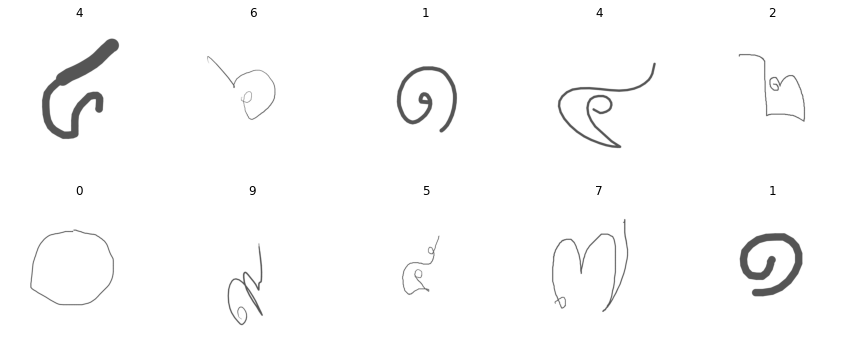

In [109]:
# sample data to be plotted
sample_df = df.sample(10)
plt.figure(figsize=(5*3,2*3))

for ind, (sample_fn, cat) in enumerate(zip(sample_df['id'], sample_df['category'])):
    
    img = mpimg.imread(src_path/sample_fn)
    plt.subplot(2, 5, ind+1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis('Off')

**Since, I have no drop list, so I will train on all of them!**

In [141]:
traingen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=20, zoom_range=0.2, validation_split=0.1, rescale=1/255.)

In [142]:
trainset = traingen.flow_from_directory('./tf-trainset', target_size=(150, 150), 
                                        seed=99, subset='training', color_mode='grayscale', class_mode='sparse')

validset = traingen.flow_from_directory('./tf-trainset', target_size=(150, 150), 
                                        seed=99, subset='validation', color_mode='grayscale', class_mode='sparse')

Found 7433 images belonging to 10 classes.
Found 822 images belonging to 10 classes.


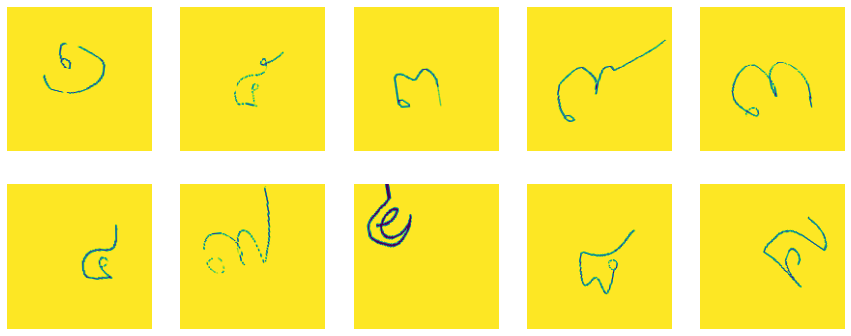

In [143]:
for data in next(trainset):
    sample_data = data[0:10, :, :, :]

    plt.figure(figsize=(5*3,2*3))
    for ind, img in enumerate(sample_data):
        plt.subplot(2, 5, ind+1)
        plt.imshow(img)
        plt.axis('Off')
    break

In [144]:
## create basic keras model
keras.backend.clear_session()


model = keras.Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.Conv2D(32, 4, activation='relu'),
    keras.layers.Conv2D(32, 4, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 4, activation='relu'),
    keras.layers.Conv2D(64, 4, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
             optimizer='adam')

In [145]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 147, 147, 32)      544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 32)      16416     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 69, 69, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 69696)             0

In [146]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [ ]:
history = model.fit(trainset, epochs=10, validation_data=validset, callbacks=[cp_cb, early_cb])